<a href="https://colab.research.google.com/github/JinHuiXu1991/Jin_DATA606/blob/main/ipynb/DATA606_Part2_ContentBasedFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Recommender Systems
## Author: Jin Hui Xu

##Content Based Filtering 

In [ ]:
!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true

!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_review.zip?raw=true

--2022-04-10 21:12:43--  https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-10 21:12:43--  https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-10 21:12:43--  https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133,

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import time
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import gzip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### Description Based Recommender (Cosine Similarity)

In [ ]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

In [ ]:
product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",NaN,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,NaN,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,NaN,the cigar moments of pleasure,the cigar book,NaN,amazon home,NaN,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,NaN,tools home improvement,2014-12-17,NaN,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


In [ ]:
product_df.shape

(30239, 13)

In [ ]:
# Replace all NaN with an empty string
product_df = product_df.fillna('')
product_df.isnull().sum()

category           0
description        0
title              0
brand              0
feature            0
main_cat           0
date               0
price              0
asin               0
imageURLHighRes    0
dateYear           0
dateMonth          0
ori_title          0
dtype: int64

In [ ]:
stop = stopwords.words('english')

In [ ]:
lem = WordNetLemmatizer()
def lemma(text):
    return ' '.join(lem.lemmatize(w) for w in text.split() if w not in stop)   

In [ ]:
product_df['description'] = product_df['description'].apply(lemma)

In [ ]:
# Define a TF-IDF Vectorizer object and remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english', max_df = 0.9, min_df = 5)

In [ ]:
# Construct the required TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(product_df['description'])

In [ ]:
# Output the shape of tfidf_matrix
tfidf_matrix.shape

(30239, 9568)

Both linear_kernel and cosine_similarity methods produce the same result. We would like to apply both methods can see the performance of creating the cosine similarity matrix, and choose the faster one.

In [ ]:
start = time.time()
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print("Time taken: %s seconds" % (time.time() - start))

Time taken: 12.935993671417236 seconds


In [ ]:
# start = time.time()
# cosine_sim2 = cosine_similarity(tfidf_matrix, tfidf_matrix)
# print("Time taken: %s seconds" % (time.time() - start))

The performance results are very close, and the linear_kernel result will be used

In [ ]:
# Reverse mapping of indices and product id
indices = pd.Series(product_df.index, index=product_df['asin'].str.lower()).drop_duplicates()

In [ ]:
# Function that takes in product id as input and gives recommendations 
def description_recommender(id, cosine_sim = cosine_sim, df = product_df, indices = indices):
  # get the index of the product that matches the id
  idx = indices[id.lower()]

  # get the pairwsie similarity scores 
  # then convert it into a list of tuples as described above
  sim_scores = list(enumerate(cosine_sim[idx]))

  # sort the product based on the cosine similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # get the scores of the 10 most similar product. Ignore the first one because it is the input product.
  sim_scores = sim_scores[1:11]

  # get the product indices
  product_indices = [i[0] for i in sim_scores]

  # return the top 10 most similar product
  return df['asin'].iloc[product_indices].tolist(), df['ori_title'].iloc[product_indices].tolist()

In [ ]:
product_df[product_df['title'].str.contains('refrigerator', case=False)].head(1)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
131,"Appliances Refrigerators, Freezers & Ice Makers",compact mini cooler warmer hold 17 liter twent...,coldmate mr 128 mini cooler warmer deluxe mini...,coldmate,press the cold button to cool to 40 f and hot ...,appliances,2001-10-02,,B0001YH10C,['https://images-na.ssl-images-amazon.com/imag...,2001,10,Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini...


In [ ]:
# get input id and title for the recommendation
input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['asin']
input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['title']

In [ ]:
#Get recommendations for Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini Refrigerator, input the product id 
asin, title = description_recommender(input_id)

In [ ]:
print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
for i in range(0, 10):
  print('{}. {}, {}'.format(i+1, asin[i], title[i]))

Description Based Recommender Result for B0001YH10C, coldmate mr 128 mini cooler warmer deluxe mini refrigerator: 
1. B00ID8CLMG, Avanti FF45006W 4.3 CF Frost Free Refrigerator Freezer, White
2. B00RNAH5OY, goFridge Mini Fridge Portable Electric Cooler
3. B001H80RN4, Frigidaire 241505301 Refrigerator Door Bin Genuine Original Equipment Manufacturer (OEM) Part
4. B004NEYPYQ, Frost-Free 4.3 Cu. Ft. Refrigerator/Freezer White
5. B000JLL3BK, Pek Vino Vault Wine Preserving Refrigerator, Silver
6. B01F79MKME, Amana AMA43BK Compact Single Door Refrigerator, 4.3 cu. ft, Black
7. B00OVI6HHW, Avanti AR4456SS Counterhigh Refrigerator, 4.5 cu. ft, Black/Stainless Steel
8. B001TIYPI0, Whirlpool Part Number 2179374: Wine Rack
9. B001F7H4RY, PORTABLE COOLER WARMER MINI FRIDGE WINE BEER
10. B001775T4C, Nostalgia Electrics CRF170RETRORED Retro Series Mini Fridge, 1.7 Cubic Feet


<b>Was trying to save the calculated cosine similarity matrix for web api use, but the matrix size is too large for local RAM or web hosting service storage and RAM. Try using another model for Web API deployment for content-based filtering. </b>

In [ ]:
# np.save('cosine_sim', cosine_sim)

In [ ]:
# original_cs = np.load("cosine_sim.npy")
# original_cs

In [ ]:
# get input id and title for the recommendation
# input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[1]['asin']
# input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[1]['title']

In [ ]:
#Get recommendations
# asin, title = description_recommender(input_id, cosine_sim=original_cs)

In [ ]:
# print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
# for i in range(0, 10):
#   print('{}. {}, {}'.format(i+1, asin[i], title[i]))

### Metadata Based Recommender (Cosine Similarity)

In [ ]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
product_df = product_df.fillna('')

In [ ]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30239 entries, 0 to 30238
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         30239 non-null  object
 1   description      30239 non-null  object
 2   title            30239 non-null  object
 3   brand            30239 non-null  object
 4   feature          30239 non-null  object
 5   main_cat         30239 non-null  object
 6   date             30239 non-null  object
 7   price            30239 non-null  object
 8   asin             30239 non-null  object
 9   imageURLHighRes  30239 non-null  object
 10  dateYear         30239 non-null  int64 
 11  dateMonth        30239 non-null  int64 
 12  ori_title        30239 non-null  object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [ ]:
# Use meta data except description and features
product_df['meta_text'] = product_df['category'] + ' ' +  product_df['title'] + ' ' +  product_df['brand'] + ' ' + product_df['main_cat'] + ' ' + product_df['price'].astype(str) + ' ' + product_df['dateYear'].astype(str) + ' ' + product_df['dateMonth'].astype(str) 
product_df['meta_text'] = product_df['meta_text'].apply(lemma)

In [ ]:
# Define a TF-IDF Vectorizer object and remove all english stopwords
tfidf2 = TfidfVectorizer(stop_words='english', max_df = 0.9, min_df = 5)

In [ ]:
tfidf_matrix2 = tfidf2.fit_transform(product_df['meta_text'])

In [ ]:
tfidf_matrix2.shape

(30239, 3381)

In [ ]:
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [ ]:
indices = pd.Series(product_df.index, index=product_df['asin'].str.lower()).drop_duplicates()

In [ ]:
# Function that takes in product id as input and gives recommendations 
def description_recommender(id, cosine_sim = cosine_sim2, df = product_df, indices = indices):
  # get the index of the product that matches the id
  idx = indices[id.lower()]

  # get the pairwsie similarity scores 
  # then convert it into a list of tuples as described above
  sim_scores = list(enumerate(cosine_sim[idx]))

  # sort the product based on the cosine similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # get the scores of the 10 most similar product. Ignore the first one because it is the input product.
  sim_scores = sim_scores[1:11]

  # get the product indices
  product_indices = [i[0] for i in sim_scores]

  # return the top 10 most similar product
  return df['asin'].iloc[product_indices].tolist(), df['ori_title'].iloc[product_indices].tolist()

In [ ]:
product_df[product_df['title'].str.contains('refrigerator', case=False)].head(1)

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title,meta_text
131,"Appliances Refrigerators, Freezers & Ice Makers",this compact mini cooler and warmer holds 17 l...,coldmate mr 128 mini cooler warmer deluxe mini...,coldmate,press the cold button to cool to 40 f and hot ...,appliances,2001-10-02,,B0001YH10C,['https://images-na.ssl-images-amazon.com/imag...,2001,10,Coldmate MR-128 Mini Cooler/Warmer Deluxe Mini...,"Appliances Refrigerators, Freezers & Ice Maker..."


In [ ]:
# get input id and title for the recommendation
input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['asin']
input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['title']

In [ ]:
#Get recommendations
asin2, title2 = description_recommender(input_id, cosine_sim=cosine_sim2)

In [ ]:
print('Description Based Recommender Result for {}, {}: '.format(input_id, input_title))
for i in range(0, 10):
  print('{}. {}, {}'.format(i+1, asin2[i], title2[i]))

Description Based Recommender Result for B0001YH10C, coldmate mr 128 mini cooler warmer deluxe mini refrigerator: 
1. B001F7H4RY, PORTABLE COOLER WARMER MINI FRIDGE WINE BEER
2. B00YNNEC8Q, Mini Wine Cooler
3. B00ND5CWAA, Phoenix USB 5v Portable One Zip-top Can Cooler-mini Car Compact Refrigerator and Warmer
4. B00YNMUYV6, Mini Wine Cooler Refrigerator with Lock
5. B00RNAH5OY, goFridge Mini Fridge Portable Electric Cooler
6. B016K4J3U2, Honeykoko Mini USB PC Refrigerator Fridge Beverage Drink Can Cooler Warmer Heater Gadget One Can in Home Office
7. B016KQ7X8E, ThreeH New Mini Red USB Fridge Cooler Beverage Drink Cans Cooler/Warmer Refrigerator for Laptop PC Computer Red H-UF05Red
8. B0187KYRQC, Coca-Cola Mini Can Cooler
9. B00KE7FM3O, Mini USB Desktop Fridge Cooler Refrigerator
10. B005JAVC94, Mini Desktop Fridge Cooler Personal Fridge(Black)


The recommendation results from the Metadata based recommender are also pretty good, the list of output products is very similar to the input product.

However, although both description-based and metadata-based models have a good performance, we are not able to deploy cosine similarity models due to the computing resource limitation of the web server. Thus, we need to find an alternative approach for the content-based filtering model.

### Topic Modeling Recommender (LDA)

The idea of content-based filtering is to find the similarity products based on either metadata or product description as we did above.

In this case, the topic modeling approach could be an alternative solution. Instead of computing the huge similarity matrix, leveraging a probabilistic topic model like LDA can cluster the entire product set into different topics or categories in our case. 

For creating recommendations, we can find the products that share the same topics among the product list and output the products with the highest probability scores. Although the output will be less precise than the cosine similarity models, it can be a good fit for our project deployment.

In [ ]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')
product_df = product_df.fillna('')

In [ ]:
product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,,the cigar moments of pleasure,the cigar book,,amazon home,,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,,tools home improvement,2014-12-17,,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


We will use all textual data for the LDA model

In [ ]:
product_df['all_text'] = product_df['category'] + ' ' + product_df['description'] + ' ' + product_df['title'] + ' ' + product_df['brand'] + ' ' + product_df['feature'] +\
                         product_df['main_cat']

Clean text, remove stopwords, tokenization

In [ ]:
words = set(nltk.corpus.words.words())

def clear_text(doc):
  #cleaned_text = " ".join(w for w in nltk.wordpunct_tokenize(cleaned_text) if w.lower() in words or not w.isalpha())
  cleaned_text = re.sub('[^a-zA-Z0-9]', ' ', doc)
  cleaned_text = re.sub('\s\s+', ' ', cleaned_text)
  cleaned_text = cleaned_text.lower()
  return cleaned_text

In [ ]:
product_df['all_text'] = product_df['all_text'].apply(clear_text)

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(product_df['all_text']))

In [ ]:
stop = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop] for doc in texts]

In [ ]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
lem = WordNetLemmatizer()
def lemma(texts):
    return [[lem.lemmatize(w) for w in simple_preprocess(str(doc))] for doc in texts]

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization
data_lemmatized = lemma(data_words_bigrams)
data_lemmatized[0]

['appliance',
 'ice_maker',
 'tupperware',
 'freezer',
 'square',
 'round',
 'container',
 'set',
 'tupperware',
 'pc',
 'set',
 'includes',
 'two',
 'cup_ml',
 'one',
 'cup_ml',
 'use',
 'keep',
 'sandwich',
 'filling',
 'salad',
 'leftover',
 'fresh',
 'refrigerator',
 'gently',
 'twist',
 'container',
 'pop',
 'frozen_food',
 'reheating',
 'dishwasher_safe',
 'set',
 'weight',
 'le',
 'oz',
 'appliance']

Create the two main inputs for the LDA topic model: the dictionary(id2word) and the corpus. 

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1)]]


<h3>Topic number parameter tuning for LDA model</h3>
The entire tuning process might take 1~2 hours to complete, the topic number with best coherence value will be chosen to build our LDA model.

Please note that the coherence values for each run might be different, so we are going to choose the best value based on this particular run.

In [ ]:
# function to build each lda model with topic num param and calculate coherence values
def compute_coherence_values(corpus, dictionary, k):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=k, 
                                          random_state=100,
                                          chunksize=100,
                                          passes=10,
                                          per_word_topics=True)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  
  return coherence_model_lda.get_coherence()

In [ ]:
# Iterate over possible number of topics.
topic_nums = [3,4,5,6,7,8,9,10,11,12,13,14,15]
coherence_scores = []

for k in topic_nums:
    coherence_score = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_scores.append(coherence_score)

coherence_df = pd.DataFrame()
coherence_df["topic_num"] = topic_nums
coherence_df['coherence_score'] = coherence_scores
coherence_df.sort_values('coherence_score', ascending=False)

,topic_num,coherence_score
6,9,0.592110
4,7,0.583974
7,10,0.576260
5,8,0.565427
11,14,0.545079
3,6,0.544410
0,3,0.543892
9,12,0.530819
12,15,0.529282
10,13,0.527939


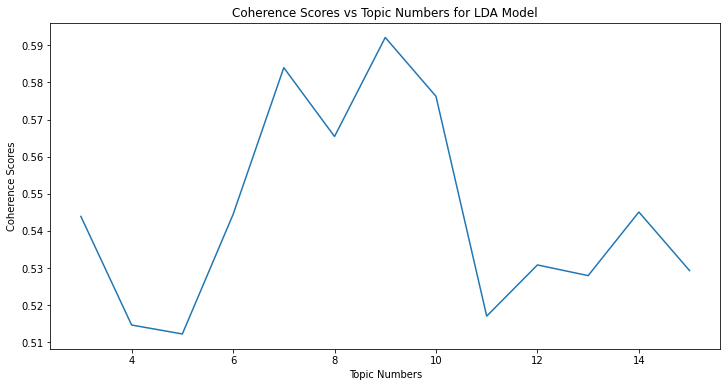

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(topic_nums, coherence_df['coherence_score'])

plt.title("Coherence Scores vs Topic Numbers for LDA Model")
plt.xlabel("Topic Numbers")
plt.ylabel("Coherence Scores")
plt.show()

The result shows that topic number 9 has the best coherence score, so we will use k=9 for the final LDA model.

In [ ]:
# Build LDA model
k=9
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Print the topics 
for index, topic in lda_model.print_topics():
  print('Topic: {} - Words: {}'.format(index, topic))

Topic: 0 - Words: 0.042*"range_hood" + 0.030*"stainless_steel" + 0.025*"filter" + 0.016*"speed" + 0.013*"inch" + 0.013*"control" + 0.012*"cfm" + 0.011*"hood" + 0.010*"air" + 0.010*"fan"
Topic: 1 - Words: 0.053*"range" + 0.041*"oven" + 0.023*"temperature" + 0.020*"gas" + 0.019*"burner" + 0.013*"cooktop" + 0.012*"humidity" + 0.011*"element" + 0.011*"heating_element" + 0.011*"knob"
Topic: 2 - Words: 0.145*"part" + 0.075*"whirlpool" + 0.050*"accessory" + 0.044*"fit" + 0.042*"oem" + 0.030*"improvement" + 0.028*"brand_models" + 0.028*"authorized" + 0.027*"number" + 0.027*"various"
Topic: 3 - Words: 0.160*"part" + 0.082*"replacement" + 0.067*"genuine" + 0.063*"accessory" + 0.037*"frigidaire" + 0.029*"model_number" + 0.028*"dryer" + 0.028*"name" + 0.026*"following_item" + 0.019*"oem"
Topic: 4 - Words: 0.011*"easy" + 0.010*"use" + 0.008*"ice" + 0.006*"add" + 0.006*"one" + 0.006*"product" + 0.006*"home" + 0.006*"make" + 0.005*"clean" + 0.005*"accessory"
Topic: 5 - Words: 0.072*"water" + 0.070*"f

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('LDA model Coherence Score: ', coherence_lda)

LDA model Coherence Score:  0.6065271075503889


In [ ]:
topic_num = []
probability = []

for n in range(len(product_df)):
  # predict the topic number
  get_document_topics = lda_model.get_document_topics(corpus[n])

  # sort by each topic numbers' probability
  sorted_doc_topics = (sorted(get_document_topics, key = lambda x: x[1], reverse = True)) 

  # get the top topic number
  topic_num.append(sorted_doc_topics[0][0]) 

   # get the top topic number probability
  probability.append(sorted_doc_topics[0][1])

product_df['topic_num'] = topic_num
product_df['probability'] = probability


In [ ]:
product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title,all_text,topic_num,probability
0,"Appliances Refrigerators, Freezers & Ice Makers",,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...,appliances refrigerators freezers ice makers t...,4,0.857793
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...,appliances refrigerators freezers ice makers 2...,4,0.730545
2,Appliances Parts & Accessories,,the cigar moments of pleasure,the cigar book,,amazon home,,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure,appliances parts accessories the cigar moments...,6,0.567891
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,,tools home improvement,2014-12-17,,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene,appliances parts accessories multi purpost des...,2,0.288812
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,appliances parts accessories range parts acces...,4,0.480673


In [ ]:
def topic_modeling_recommender(id, df):
    id = id.lower()

    # get the input product topic number
    topic_num = df[df['asin'].str.lower() == id]['topic_num'].item()

    # remove the input product from the recommendation data
    exclude_input_df = df.copy()
    exclude_input_df = exclude_input_df[exclude_input_df['asin'].str.lower() != id]

    # get the top 10 Probability product for the matching topic number
    output_df = exclude_input_df[exclude_input_df['topic_num'] == topic_num].sort_values('probability', ascending=False).head(10)

    # get the product indices
    product_indices = output_df.index.tolist()

    # return the top 10 most similar product
    return df['asin'].iloc[product_indices].tolist(), df['ori_title'].iloc[product_indices].tolist()

In [ ]:
# get input id and title for the recommendation
input_id = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['asin']
input_title = product_df[product_df['title'].str.contains('refrigerator', case=False)].iloc[0]['title']

In [ ]:
#Get recommendations
asin3, title3 = topic_modeling_recommender(input_id, product_df)

In [ ]:
print('Topic Modeling Recommender Result for {}, {}: '.format(input_id, input_title))
for i in range(0, 10):
  print('{}. {}, {}'.format(i+1, asin3[i], title3[i]))

Topic Modeling Recommender Result for B0001YH10C, coldmate mr 128 mini cooler warmer deluxe mini refrigerator: 
1. B013PRRB4W, Power Pair Special-LG Turbo Series Ultra-Capacity Laundry System with Steam*PURE WHITE COLOR*(WM4270HWA_DLEX4270W)
2. B013PSOBNA, Power Pair Special-LG Turbo Series Ultra-Capacity Laundry System with Steam and Matching Storage Pedestals *GRAPHITE STEEL*(WM4270HVA_DLEX4270V_WDP4V X 2)
3. B013PT1PFQ, Power Pair Special-LG Turbo Series Ultra-Capacity Laundry System with Steam*GRAPHITE STEEL*(WM4270HVA_DLEX4270V)
4. B00HX3ZJKS, PAIR SPECIAL- LG Turbo Series Ultra Capacity Laundry System With Steam Technology (WM3470HVA,DLEX3470V,WDP4V x2)
5. B0049OSUD2, Maytag MFI2665XEM Ice2O 25.5 Cu. Ft. Stainless Steel French Door Refrigerator - Energy Star
6. B00MG225MQ, Power Pair Special- LG Turbo Series Ultra Capacity Laundry System with Steam Technology(WM3570HWA_DLEX3570W)*PURE WHITE IN COLOR*
7. B00MG17WBQ, POWER PAIR SPECIAL-LG TURBO SERIES ULTRA CAPACITY LAUNDRY SYSTEM 

The LDA model has a Coherence Score:  0.606, and The LDA topic modeling recommender did a fairly good job. However, the cosine similarity models are performing better and generating more concise recommendations.



<b>Since it is just adding extra topic number and probability columns to the dataset, the data file size would be much smaller than the cosine similarity model for deployment. Thus, save the LDA model output for future Web API use.</b>

In [ ]:
compression_opts = dict(method='zip',archive_name='Content_based_LDA_output.csv')  
product_df.to_csv('Content_based_LDA_output.zip', index=False, header = True, compression=compression_opts)